**IMPORTATIONS DES PACKAGES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cdist
from math import pi

In [2]:
# Chemin vers le fichier GZIP
gzip_file_path = "C:/Users/HanSAriEle/OneDrives/Desktop/PROJET_TUTORE/database_quality_ofair.csv.gz"

# Lire le fichier CSV directement depuis le fichier GZIP
data = pd.read_csv(gzip_file_path, compression='gzip')

# Afficher les premières lignes du DataFrame pour vérifier
data.head()

,Date,City,Country_Name,Continent,aqi,co,neph,no2,o3,pm10,pm25,so2,Categorie
0,2019-01-01,Addis Ababa,Ethiopia,Africa,38.0,1.933333,23.333333,7.333333,16.533333,15.333333,38.000000,1.266667,Bon
1,2019-01-01,Adelaide,Australia,Oceania,7.0,0.100000,3.666667,0.100000,0.000000,7.000000,6.000000,0.100000,Bon
2,2019-01-01,Barcelona,Spain,Europe,27.0,0.100000,9.666667,17.000000,4.900000,27.000000,27.666667,4.600000,Bon
3,2019-01-01,Bilbao,Spain,Europe,68.0,0.100000,39.000000,12.800000,3.300000,23.000000,68.000000,4.000000,Modéré
4,2019-01-01,Bogotá,Colombia,South America,34.0,4.600000,8.666667,2.300000,8.300000,17.000000,34.000000,0.300000,Bon


**ANALYSES BIVARIEES**

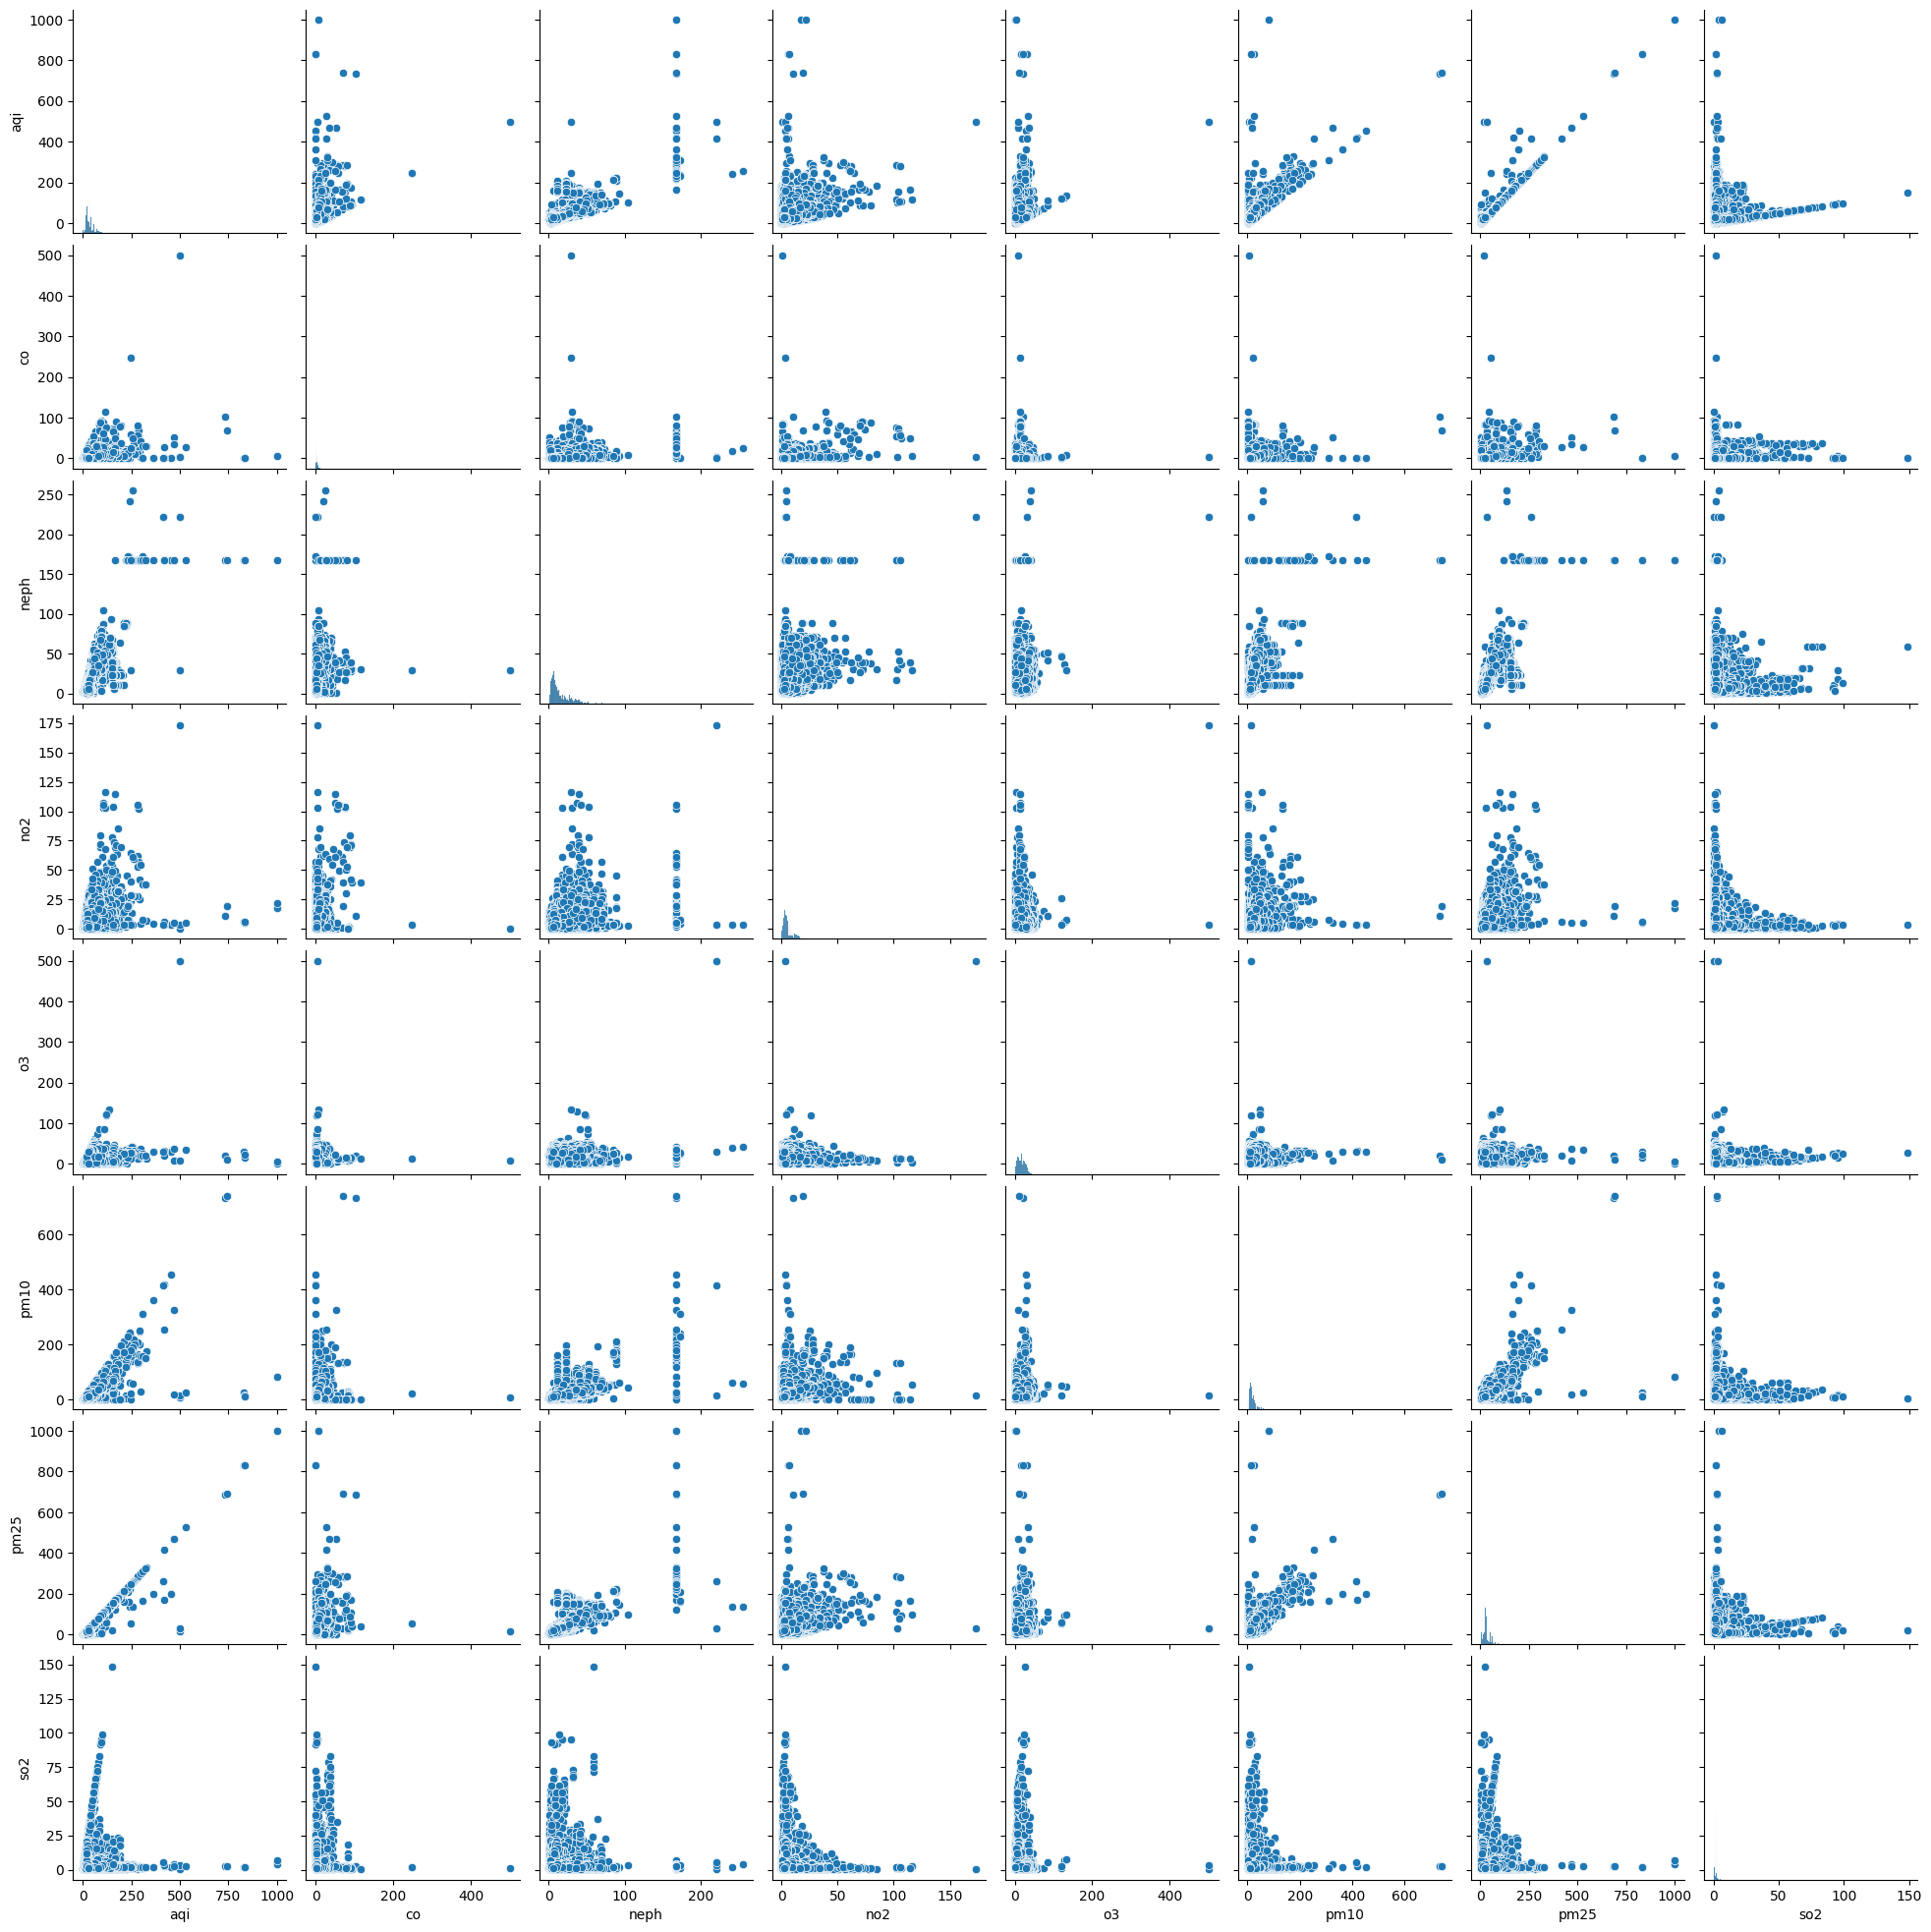

In [3]:
# Graphiques bivariés
sns.pairplot(data)
plt.show()

In [4]:
# Sélectionner uniquement les colonnes numériques
df_numeric = data.select_dtypes(include=[np.number])

# Calculer la corrélation de Spearman
correlation_spearman = df_numeric.corr(method='spearman')

# Afficher le résultat
correlation_spearman

,aqi,co,neph,no2,o3,pm10,pm25,so2
aqi,1.000000,0.294864,0.885377,0.394667,0.127409,0.762278,0.940090,0.111090
co,0.294864,1.000000,0.309639,0.084546,-0.406617,0.313392,0.316583,-0.111112
neph,0.885377,0.309639,1.000000,0.421291,-0.017007,0.852415,0.927013,0.066971
no2,0.394667,0.084546,0.421291,1.000000,-0.004998,0.388208,0.442320,0.140547
o3,0.127409,-0.406617,-0.017007,-0.004998,1.000000,0.004168,0.003024,0.168610
pm10,0.762278,0.313392,0.852415,0.388208,0.004168,1.000000,0.804426,0.087149
pm25,0.940090,0.316583,0.927013,0.442320,0.003024,0.804426,1.000000,0.092797
so2,0.111090,-0.111112,0.066971,0.140547,0.168610,0.087149,0.092797,1.000000


**REALISATION DE L'ACP**

In [61]:
# Sélectionner uniquement les colonnes numériques pour l'agrégation
numeric_columns = ['aqi', 'co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']
non_numeric_columns = ['City', 'Country_Name', 'Continent']

# Vérifier que les colonnes sélectionnées existent dans les données
for col in numeric_columns:
    if col not in data.columns:
        print(f"Warning: {col} not found in data columns")


# Agréger les données par ville (en utilisant les colonnes numériques)
agg_data_numeric = data.groupby('City')[numeric_columns].mean().reset_index()

# Conserver les informations non numériques pour les premières occurrences
agg_data_non_numeric = data[non_numeric_columns].drop_duplicates(subset=['City']).reset_index(drop=True)

# Combiner les données agrégées avec les informations non numériques
agg_data = pd.merge(agg_data_non_numeric, agg_data_numeric, on='City')


# Standardiser les données
X = agg_data[numeric_columns]
scaler = StandardScaler()
df_normalized = scaler.fit_transform(X)

# ACP
pca = PCA()
df_pca = pca.fit_transform(df_normalized)

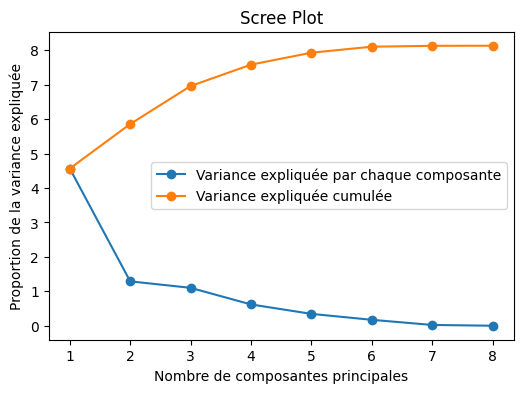

In [62]:
# Calculer la variance expliquée cumulée
explained_variance = pca.explained_variance_

cumulative_explained_variance = np.cumsum(explained_variance)

# Créer un scree plot avec la variance expliquée cumulée
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', label='Variance expliquée par chaque composante')
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, 'o-', label='Variance expliquée cumulée')
plt.title('Scree Plot')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de la variance expliquée')
plt.legend()
plt.show()

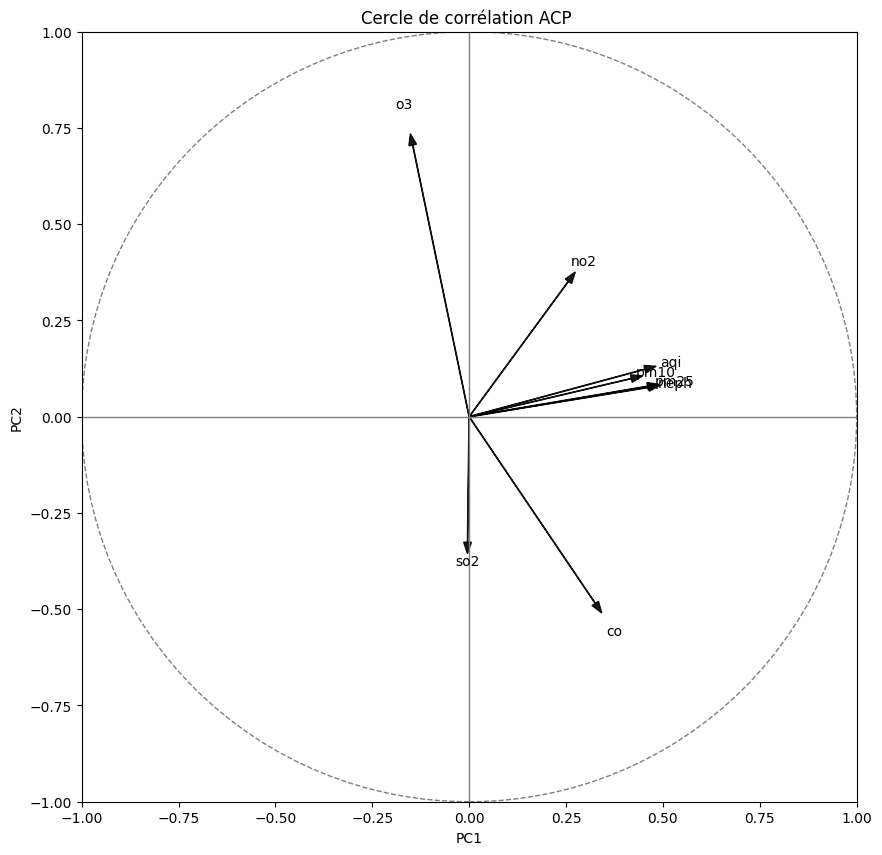

In [63]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

# Créer la figure
plt.figure(figsize=(10, 10))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, df_numeric.columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle de corrélation ACP ')

# Afficher la figure
plt.show()

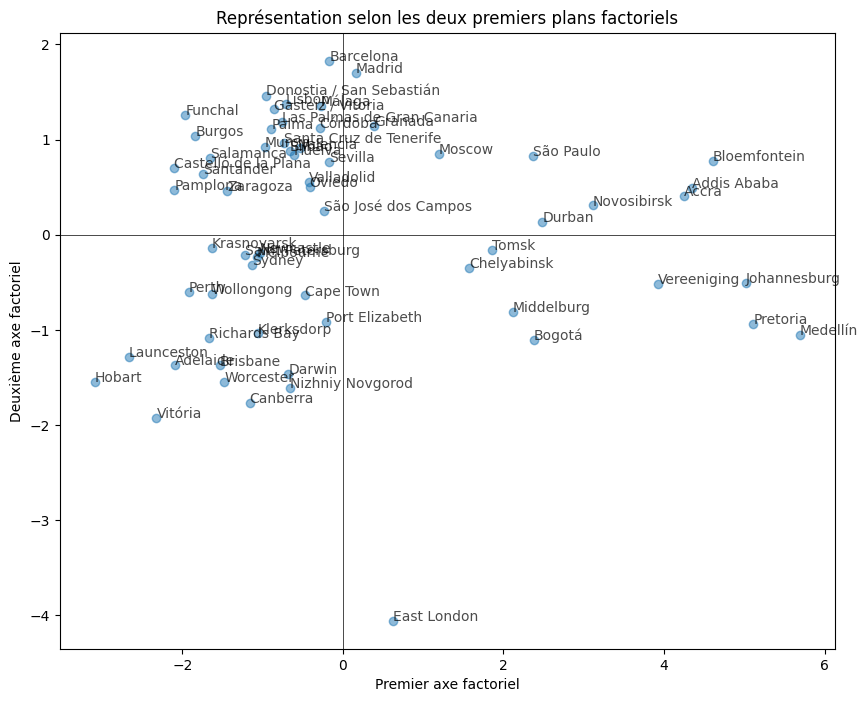

In [67]:
# Créer le graphique du premier plan factoriel
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5)

# Ajouter des étiquettes pour chaque point (ville)
for i, city in enumerate(data['City'].unique()):
    ax.annotate(city, (df_pca[i, 0], df_pca[i, 1]), alpha=0.7)

# Ajouter des axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Labels des axes
ax.set_xlabel('Premier axe factoriel')
ax.set_ylabel('Deuxième axe factoriel')

# Titre du graphique
plt.title('Représentation selon les deux premiers plans factoriels')

# Afficher le graphique
plt.show()

In [68]:
# Choix du nombre optimal de clusters (méthode du coude et du score de silhouette)
inertias = []
silhouettes = []
K = range(2, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(df_normalized)
    inertias.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_score(df_normalized, kmeanModel.labels_))

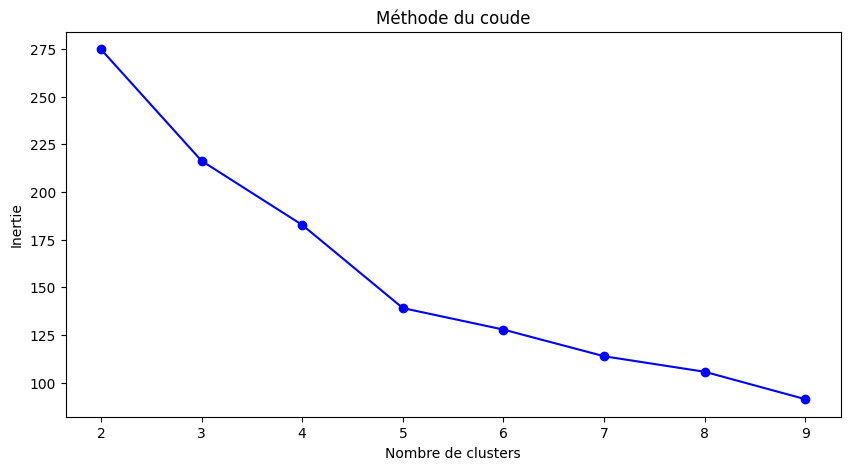

In [69]:
# Tracer la courbe de l'inertie
plt.figure(figsize=(10, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()

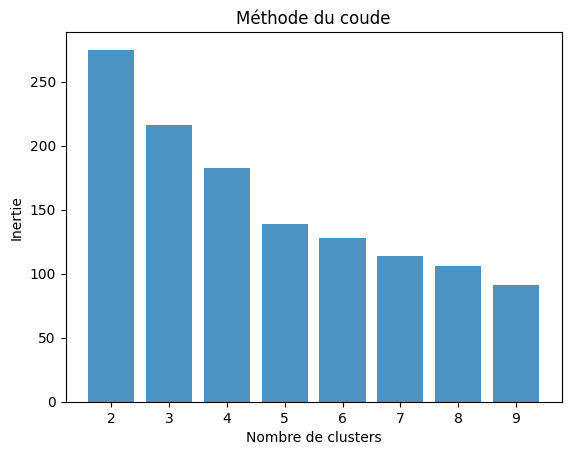

In [70]:
plt.bar(range(2, 10), inertias, align='center', alpha=0.8)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()

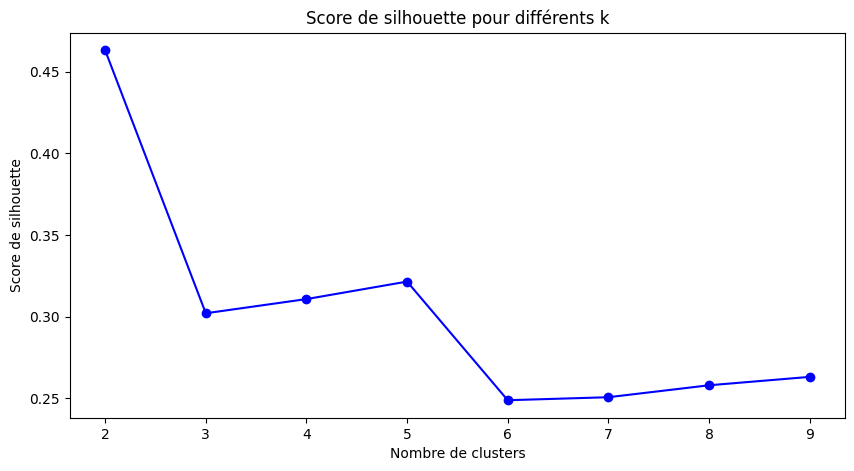

In [72]:
# Tracer le score de silhouette
plt.figure(figsize=(10, 5))
plt.plot(K, silhouettes, 'bo-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette pour différents k')
plt.show()

In [73]:
optimal_k = K[silhouettes.index(max(silhouettes))]
kmeanModel = KMeans(n_clusters=optimal_k, random_state=42)

In [74]:
# Ajouter les labels de cluster au DataFrame
data['cluster_label'] = kmeanModel.fit_predict(df_normalized)
data.head()

ValueError: Length of values (62) does not match length of index (101227)

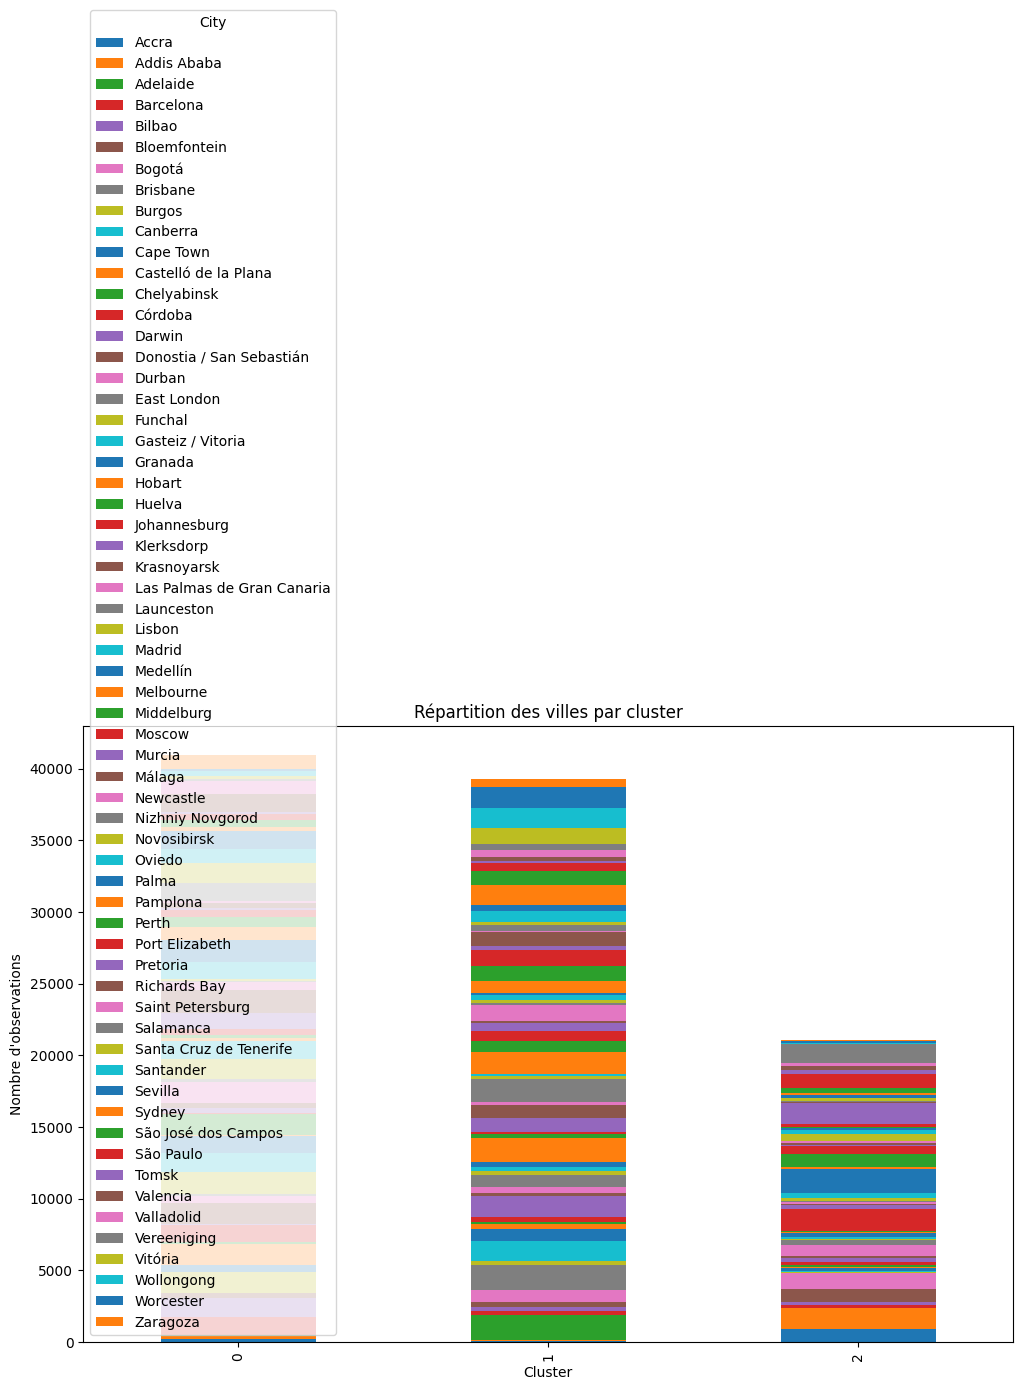

In [75]:
# Créer une table de contingence entre cluster_label et City
contingency_table = pd.crosstab(data['cluster_label'], data['City'])

# Tracer le barplot
contingency_table.plot(kind='bar', stacked=True, figsize=(12, 8))

# Ajouter des étiquettes et des titres
plt.xlabel('Cluster')
plt.ylabel("Nombre d'observations")
plt.title('Répartition des villes par cluster')

# Afficher la légende
plt.legend(title='City')

# Afficher le graphique
plt.show()

In [78]:
# Afficher les villes par cluster
n_clusters = 3
for cluster_num in range(n_clusters) :
    cities_in_cluster = set(data[data['cluster_label'] == cluster_num]['City'])
    print(len(cities_in_cluster))
    print(f"Cluster {cluster_num}: {', '.join(cities_in_cluster)}", "\n ")

62
Cluster 0: São Paulo, Melbourne, Salamanca, Murcia, Madrid, Donostia / San Sebastián, Richards Bay, Pretoria, Brisbane, Zaragoza, Santander, Nizhniy Novgorod, Barcelona, Córdoba, Granada, Valencia, Cape Town, Perth, Oviedo, Medellín, Las Palmas de Gran Canaria, East London, Worcester, Gasteiz / Vitoria, Palma, Huelva, Johannesburg, Hobart, Port Elizabeth, Vereeniging, Bogotá, Moscow, Castelló de la Plana, Launceston, Málaga, Durban, Tomsk, Saint Petersburg, Wollongong, Novosibirsk, Lisbon, Adelaide, Middelburg, Krasnoyarsk, Accra, Addis Ababa, Funchal, Sevilla, Pamplona, Bilbao, Newcastle, São José dos Campos, Klerksdorp, Darwin, Valladolid, Canberra, Santa Cruz de Tenerife, Sydney, Vitória, Bloemfontein, Burgos, Chelyabinsk 
 
62
Cluster 1: Murcia, Melbourne, Salamanca, São Paulo, Madrid, Donostia / San Sebastián, Richards Bay, Pretoria, Brisbane, Zaragoza, Santander, Nizhniy Novgorod, Barcelona, Córdoba, Granada, Valencia, Cape Town, Perth, Oviedo, East London, Las Palmas de Gran 

In [ ]:
# Variables numériques à comparer avec l'AQI
numeric_variables = ['co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']

# Créer une figure avec une taille spécifique
plt.figure(figsize=(18, 12))

# Couleurs pour chaque cluster
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'grey']

# Boucle sur chaque variable numérique
for i, variable in enumerate(numeric_variables):
    plt.subplot(3, 3, i + 1)  # Créer un subplot
    for cluster_num in range(n_clusters):
        cluster_data = data[data['cluster_label'] == cluster_num]
        plt.scatter(cluster_data[variable], cluster_data['aqi'], label=f'Cluster {cluster_num}', s=100, color=colors[cluster_num])
    plt.xlabel(variable.capitalize())  # Nom de l'axe x
    plt.ylabel('AQI')  # Nom de l'axe y
    plt.title(f'AQI en fonction de {variable.capitalize()}')  # Titre du subplot
    plt.legend()  # Légende
    plt.grid(True)  # Grille

plt.tight_layout()  # Ajustement automatique des subplots
plt.show() 

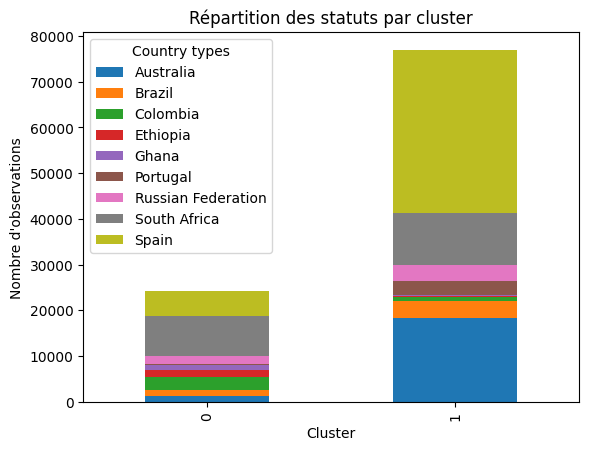

In [28]:
# Créer une table de contingence entre cluster_label et statut_types
contingency_table_2 = pd.crosstab(data['cluster_label'], data['Country_Name'])

# Tracer le barplot
contingency_table_2.plot(kind='bar', stacked=True)

# Ajouter des étiquettes et des titres
plt.xlabel('Cluster')
plt.ylabel("Nombre d'observations")
plt.title('Répartition des statuts par cluster')

# Afficher la légende
plt.legend(title='Country types')

# Afficher le graphique
plt.show()

In [30]:
# Afficher les villes par cluster
n_clusters = 2
for cluster_num in range(n_clusters):
    cities_in_cluster = set(data[data['cluster_label'] == cluster_num]['Country_Name'])
    print(len(cities_in_cluster))
    print(f"Cluster {cluster_num}: {', '.join(cities_in_cluster)}", "\n ")

9
Cluster 0: Ethiopia, Brazil, Ghana, Russian Federation, Portugal, Australia, Spain, Colombia, South Africa 
 
9
Cluster 1: Ethiopia, Brazil, Ghana, Russian Federation, Portugal, Australia, Spain, Colombia, South Africa 
 


In [79]:
#Nombre de clusters
n_clusters = len(data['cluster_label'].unique())

# Créer une figure avec une taille spécifique
plt.figure(figsize=(18, 12))

# Couleurs pour chaque cluster
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'grey']

# Boucle sur chaque variable numérique
for i, variable in enumerate(numeric_variables):
    plt.subplot(3, 3, i + 1)  # Créer un subplot
    for cluster_num in range(n_clusters):
        cluster_data = data[data['cluster_label'] == cluster_num]
        plt.scatter(cluster_data[variable], cluster_data['aqi'], label=f'Cluster {cluster_num}', s=100, color=colors[cluster_num])
    plt.xlabel(variable.capitalize())  # Nom de l'axe x
    plt.ylabel('AQI')  # Nom de l'axe y
    plt.title(f'AQI en fonction de {variable.capitalize()}')  # Titre du subplot
    plt.legend()  # Légende
    plt.grid(True)  # Grille

plt.tight_layout()  # Ajustement automatique des subplots
plt.show()  # Afficher le graphique

NameError: name 'numeric_variables' is not defined

<Figure size 1800x1200 with 0 Axes>

In [ ]:
# Encodage de la colonne 'Categorie'
label_encoder = LabelEncoder()
data['Categorie_encoded'] = label_encoder.fit_transform(data['Categorie'])

# Sélectionner les colonnes numériques pour le clustering
numeric_columns = ['aqi', 'co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'Categorie_encoded']
data_for_clustering = data[numeric_columns]

# Normalisation des données
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_for_clustering)

# Application de KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_normalized)

# Ajout des labels de clusters au DataFrame original
data['Cluster'] = kmeans.labels_

data

# Visualiser les clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='aqi', y='pm25', hue='Cluster', data=data, palette='viridis')
plt.title('Clustering des données basé sur la qualité de l\'air et les polluants')
plt.show()

In [46]:
data['Categorie'].unique()

array(['Bon', 'Modéré', 'Mauvais', 'Mauvais pour les groupes sensibles',
       'Dangereux', 'Très mauvais'], dtype=object)

In [ ]:
data[data['Categorie'] == 'Très mauvais']

In [ ]:
data['Cluster'].unique()

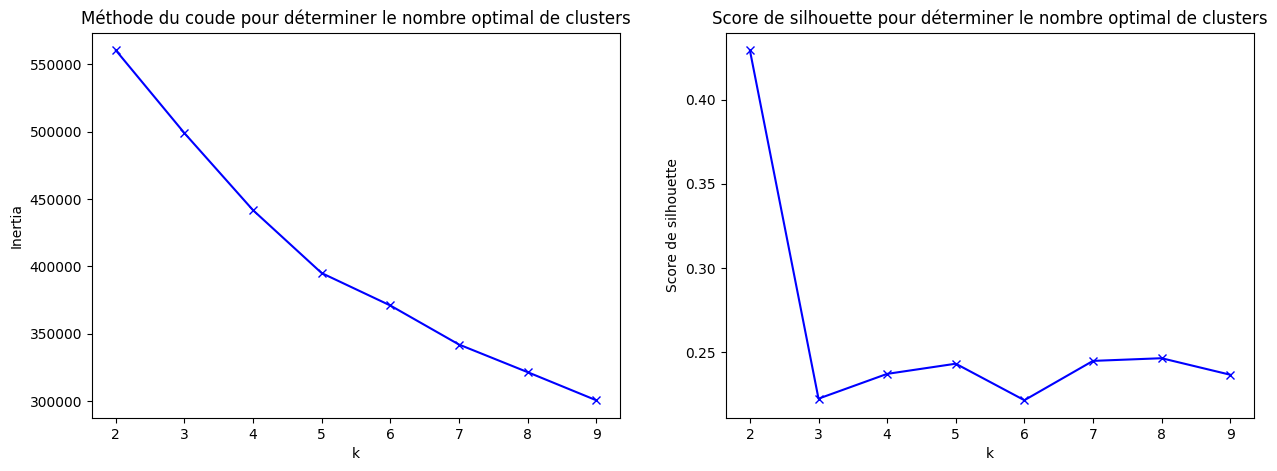

                     aqi        co       neph        no2         o3  \
cluster_label                                                         
0              34.485491  1.026310  13.067907   5.709149  25.822616   
1              20.920443  1.955085   7.828596   4.940724   9.788247   
2              73.779353  6.035150  35.501450  10.623549  11.439476   

                    pm10       pm25       so2  
cluster_label                                  
0              16.944389  30.931937  2.065798  
1              11.871388  19.982289  1.946569  
2              38.220437  73.331589  2.397186  
Villes avec une qualité de l'air Bon: Addis Ababa, Adelaide, Barcelona, Bogotá, Brisbane, Burgos, Castelló de la Plana, Córdoba, Darwin, Granada, Hobart, Huelva, Klerksdorp, Las Palmas de Gran Canaria, Launceston, Melbourne, Middelburg, Moscow, Murcia, Málaga, Palma, Pamplona, Perth, Port Elizabeth, Pretoria, Richards Bay, Salamanca, Santa Cruz de Tenerife, Santander, Sevilla, São José dos Campos, Add

In [47]:
# Sélection des colonnes pertinentes
features = ['aqi', 'co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']
X = data[features]

# Normalisation des données
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Choix du nombre optimal de clusters
inertias = []
silhouettes = []
K = range(2, 10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(X_normalized)
    inertias.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_score(X_normalized, kmeanModel.labels_))

# Visualisation pour déterminer le nombre optimal de clusters
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')

plt.subplot(1, 2, 2)
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette pour déterminer le nombre optimal de clusters')

plt.show()

# Application du clustering avec le nombre de clusters optimal
optimal_clusters = 3  # Remplacez par le nombre optimal déterminé
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['cluster_label'] = kmeans.fit_predict(X_normalized)

# Calcul des moyennes des indicateurs de pollution par cluster
cluster_means = data.groupby('cluster_label')[features].mean()
print(cluster_means)

# Définir les seuils pour chaque catégorie de qualité de l'air
quality_thresholds = {
    'Bon': {
        'aqi': 50
    },
    'Modéré': {
        'aqi': 100
    },
    'Mauvais pour les groupes sensibles': {
        'aqi': 150
    },
    'Mauvais': {
        'aqi': 200
    },
    'Très mauvais': {
        'aqi': 300
    },
    'Dangereux': {
        'aqi': float('inf')
    }
}

# Fonction pour déterminer la qualité de l'air en fonction des seuils
def determine_quality(aqi):
    if aqi <= 50:
        return 'Bon'
    elif aqi <= 100:
        return 'Modéré'
    elif aqi <= 150:
        return 'Mauvais pour les groupes sensibles'
    elif aqi <= 200:
        return 'Mauvais'
    elif aqi <= 300:
        return 'Très mauvais'
    else:
        return 'Dangereux'

# Mapper les labels des clusters aux catégories de qualité de l'air
data['air_quality'] = data['aqi'].apply(determine_quality)

# Affichage des villes par catégorie de qualité de l'air des clusters
for quality in quality_thresholds.keys():
    cities = data[data['air_quality'] == quality]['City'].tolist()
    print(f"Villes avec une qualité de l'air {quality}: {', '.join(cities)}")

Cluster 0:
['Addis Ababa', 'Funchal', 'Las Palmas de Gran Canaria', 'Moscow', 'Málaga', 'Newcastle', 'Pamplona', 'Santa Cruz de Tenerife', 'Sydney', 'São José dos Campos', 'Wollongong', 'Addis Ababa', 'Bilbao', 'Donostia / San Sebastián', 'Gasteiz / Vitoria', 'Las Palmas de Gran Canaria', 'Medellín', 'Moscow', 'Málaga', 'Santa Cruz de Tenerife', 'Sydney', 'São Paulo', 'Bilbao', 'Burgos', 'Castelló de la Plana', 'Funchal', 'Klerksdorp', 'Las Palmas de Gran Canaria', 'Oviedo', 'Palma', 'Santa Cruz de Tenerife', 'Sydney', 'São Paulo', 'Castelló de la Plana', 'Funchal', 'Las Palmas de Gran Canaria', 'Melbourne', 'Málaga', 'Port Elizabeth', 'Santa Cruz de Tenerife', 'Castelló de la Plana', 'Funchal', 'Johannesburg', 'Las Palmas de Gran Canaria', 'Newcastle', 'Palma', 'Pretoria', 'Salamanca', 'Santa Cruz de Tenerife', 'Sydney', 'Vereeniging', 'Burgos', 'Castelló de la Plana', 'Darwin', 'Funchal', 'Las Palmas de Gran Canaria', 'Newcastle', 'Salamanca', 'Santa Cruz de Tenerife', 'Sydney', 'Wol

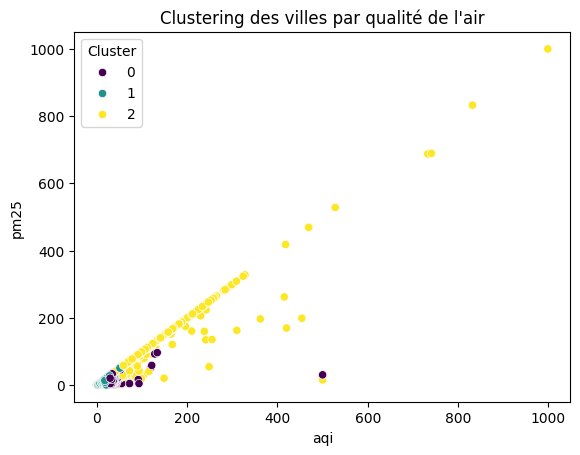

               City  Cluster
0       Addis Ababa        0
1          Adelaide        1
2         Barcelona        1
3            Bilbao        2
4            Bogotá        1
...             ...      ...
101222  Vereeniging        1
101223      Vitória        1
101224   Wollongong        1
101225    Worcester        1
101226     Zaragoza        0

[101227 rows x 2 columns]


In [49]:
# Sélectionner les colonnes pertinentes pour le clustering
features = ['aqi', 'co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']
X = data[features]

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer K-means avec un nombre de clusters souhaité (par exemple, 3)
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Afficher les différentes villes dans chaque cluster
for cluster in data['Cluster'].unique():
    print(f"Cluster {cluster}:")
    print(data[data['Cluster'] == cluster]['City'].tolist())
    print("\n")

# Visualiser les résultats
sns.scatterplot(x='aqi', y='pm25', hue='Cluster', data=data, palette='viridis')
plt.title('Clustering des villes par qualité de l\'air')
plt.show()

print(data[['City', 'Cluster']])

In [50]:
# Agréger les données par ville
agg_data = data.groupby('City').mean().reset_index()

# Sélectionner les colonnes pertinentes pour le clustering
features = ['aqi', 'co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']
X = agg_data[features]

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Déterminer le nombre optimal de clusters (facultatif, méthode elbow)
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Appliquer K-means avec un nombre de clusters choisi (par exemple, 3)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
agg_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Afficher les différentes villes dans chaque cluster
for cluster in range(n_clusters):
    print(f"Cluster {cluster}:")
    print(agg_data[agg_data['Cluster'] == cluster]['City'].tolist())
    print("\n")

# Visualiser les résultats (par exemple, avec AQI et PM2.5)
sns.scatterplot(x='aqi', y='pm25', hue='Cluster', data=agg_data, palette='viridis')
plt.title('Clustering des villes par niveau de pollution')
plt.show()

TypeError: agg function failed [how->mean,dtype->object]

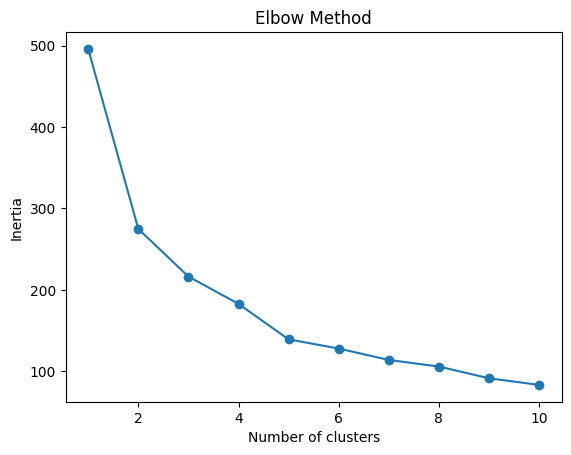

Cluster 0:
['Adelaide', 'Brisbane', 'Darwin', 'Hobart', 'Klerksdorp', 'Launceston', 'Melbourne', 'Newcastle', 'Perth', 'Port Elizabeth', 'Richards Bay', 'Sydney', 'Wollongong', 'East London', 'Cape Town', 'Worcester', 'Canberra', 'Krasnoyarsk', 'Vitória', 'Nizhniy Novgorod', 'Saint Petersburg']


Cluster 1:
['Addis Ababa', 'Bogotá', 'Johannesburg', 'Medellín', 'Middelburg', 'Pretoria', 'São Paulo', 'Vereeniging', 'Bloemfontein', 'Durban', 'Chelyabinsk', 'Novosibirsk', 'Tomsk', 'Accra']


Cluster 2:
['Barcelona', 'Bilbao', 'Burgos', 'Castelló de la Plana', 'Córdoba', 'Donostia / San Sebastián', 'Funchal', 'Gasteiz / Vitoria', 'Granada', 'Huelva', 'Las Palmas de Gran Canaria', 'Lisbon', 'Madrid', 'Moscow', 'Murcia', 'Málaga', 'Oviedo', 'Palma', 'Pamplona', 'Salamanca', 'Santa Cruz de Tenerife', 'Santander', 'Sevilla', 'São José dos Campos', 'Valencia', 'Valladolid', 'Zaragoza']




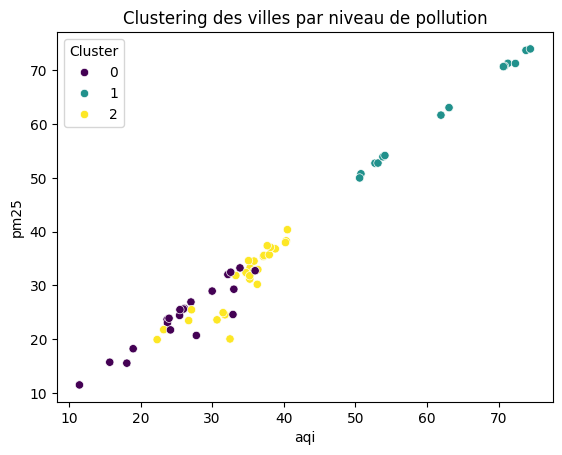

In [51]:
# Sélectionner uniquement les colonnes numériques pour l'agrégation
numeric_columns = ['aqi', 'co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']
non_numeric_columns = ['City', 'Country_Name', 'Continent']

# Vérifier que les colonnes sélectionnées existent dans les données
for col in numeric_columns:
    if col not in data.columns:
        print(f"Warning: {col} not found in data columns")
        
# Agréger les données par ville (en utilisant les colonnes numériques)
agg_data_numeric = data.groupby('City')[numeric_columns].mean().reset_index()

# Conserver les informations non numériques pour les premières occurrences
agg_data_non_numeric = data[non_numeric_columns].drop_duplicates(subset=['City']).reset_index(drop=True)

# Combiner les données agrégées avec les informations non numériques
agg_data = pd.merge(agg_data_non_numeric, agg_data_numeric, on='City')

# Standardiser les données
X = agg_data[numeric_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Déterminer le nombre optimal de clusters (facultatif, méthode elbow)
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Appliquer K-means avec un nombre de clusters choisi (par exemple, 3)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
agg_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Afficher les différentes villes dans chaque cluster
for cluster in range(n_clusters):
    print(f"Cluster {cluster}:")
    print(agg_data[agg_data['Cluster'] == cluster]['City'].tolist())
    print("\n")

# Visualiser les résultats (par exemple, avec AQI et PM2.5)
sns.scatterplot(x='aqi', y='pm25', hue='Cluster', data=agg_data, palette='viridis')
plt.title('Clustering des villes par niveau de pollution')
plt.show()